In [2]:
# Random Forest Algorithm

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [62]:
shipping_data = pd.read_csv("ShippingData1.csv")

In [64]:
shipping_data

,CONTAINER_ID,LINE_CODE,CONTAINER_DATE,DATE,DAY,TIME,AM/PM,CONTAINER_TYPE_CODE,CONTAINER_TYPE,CONTAINER_ISO_CODE,CONTAINER_LENGTH,CONTAINER_HEIGHT,CONTAINER_WIDTH,VENTILATION,DANGEROUS_TRANSPORT,DESIGNATION_CODE,DESIGNATION,TIME_24HR
0,TRLU5869252,HLL,2/3/2024 0:01,2/3/2024,Saturday,12:01:00,AM,HC,High Cubed,45G1,40,9'6'',8,No Ventilation,No,MT,Empty,00:01:00
1,WIKU5201240,MLH,6/21/2024 12:34,6/21/2024,Friday,12:34:00,PM,HC,High Cubed,45G1,40,9'6'',8,No Ventilation,No,EXP,Export Service,12:34:00
2,ESDU4075587,ESL,7/15/2024 12:21,7/15/2024,Monday,12:21:00,PM,HC,High Cubed,45G1,40,9'6'',8,No Ventilation,No,T/S,Transhipment,12:21:00
3,WFHU5195877,ESL,7/15/2024 12:21,7/15/2024,Monday,12:21:00,PM,HC,High Cubed,45G1,40,9'6'',8,No Ventilation,No,T/S,Transhipment,12:21:00
4,GCSU2021209,NVSL,8/3/2024 10:15,8/3/2024,Saturday,10:15:00,AM,STD,Standard,22G1,20,8'6'',8,No Ventilation,No,EXP,Export Service,10:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,CSDU3426685,MSK,10/18/2024 8:43,10/18/2024,Friday,8:43:00,AM,STD,Standard,22G1,20,8'6'',8,No Ventilation,No,EXP,Export Service,08:43:00
996,TSLU0510425,TLPL,10/18/2024 9:17,10/18/2024,Friday,9:17:00,AM,HC,High Cubed,4500,40,9'6'',8,No Ventilation,No,T/S,Transhipment,09:17:00
997,TXGU8059404,YML,10/18/2024 10:26,10/18/2024,Friday,10:26:00,AM,HC,High Cubed,4500,40,9'6'',8,No Ventilation,No,MT,Empty,10:26:00
998,WFHU1306062,YML,10/18/2024 10:26,10/18/2024,Friday,10:26:00,AM,STD,Standard,2200,20,8'6'',8,No Ventilation,No,MT,Empty,10:26:00


In [66]:
def assign_time_window(time):
    hour = int(time.split(":")[0])
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

shipping_data['Time Window'] = shipping_data['TIME_24HR'].apply(assign_time_window)

In [68]:
shipping_data['Time Window']

0          Night
1      Afternoon
2      Afternoon
3      Afternoon
4        Morning
         ...    
995      Morning
996      Morning
997      Morning
998      Morning
999      Morning
Name: Time Window, Length: 1000, dtype: object

In [70]:
# Encode categorical features
label_encoders = {}
for column in ['DAY', 'CONTAINER_TYPE', 'Time Window', 'DESIGNATION', 'VENTILATION']:
    le = LabelEncoder()
    shipping_data[column] = le.fit_transform(shipping_data[column])
    label_encoders[column] = le

In [72]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['CONTAINER_LENGTH']
shipping_data[numerical_features] = scaler.fit_transform(shipping_data[numerical_features])

# Define input features and target variable
X = shipping_data[['DAY', 'CONTAINER_TYPE', 'VENTILATION', 'DESIGNATION', 'CONTAINER_LENGTH']]
y = shipping_data['Time Window']  # Target is the time window

In [74]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 splits

In [76]:
# Initialize an array to accumulate feature importance across folds
feature_importance_accumulator = np.zeros(X.shape[1])

In [78]:
# Initialize metrics to track performance
fold_accuracies = []
fold_reports = []

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # Train the model on the training set
    rf_model.fit(X_train, y_train)

    # Accumulate feature importance
    feature_importance_accumulator += rf_model.feature_importances_

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)
    
    # Generate a classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    fold_reports.append(report)

    # Print fold-specific results
    print(f"Fold {fold} Accuracy: {accuracy:.2f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 50)

Fold 1 Accuracy: 0.59
Confusion Matrix:
[[44  2 28  1]
 [ 9 10  8  1]
 [24  6 62  0]
 [ 2  0  1  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.59      0.57        75
           1       0.56      0.36      0.43        28
           2       0.63      0.67      0.65        92
           3       0.50      0.40      0.44         5

    accuracy                           0.59       200
   macro avg       0.56      0.50      0.52       200
weighted avg       0.59      0.59      0.58       200

--------------------------------------------------
Fold 2 Accuracy: 0.58
Confusion Matrix:
[[42  6 32  1]
 [ 5  3 13  0]
 [15  1 71  0]
 [ 5  0  5  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.52      0.57        81
           1       0.30      0.14      0.19        21
           2       0.59      0.82      0.68        87
           3       0.50      0.09      0.15      

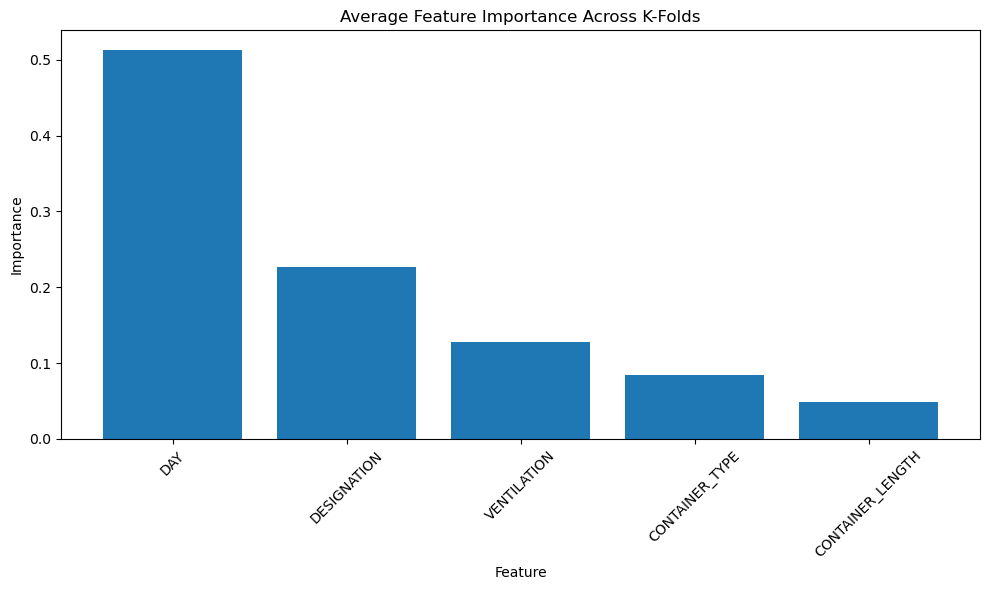

In [79]:
# Average feature importance across all folds
average_feature_importance = feature_importance_accumulator / kf.get_n_splits()

# Plot feature importance
features = X.columns
indices = np.argsort(average_feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), average_feature_importance[indices], align='center')
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Average Feature Importance Across K-Folds")
plt.tight_layout()
plt.show()